<a href="https://colab.research.google.com/github/hun9008/ML_TeamProject_24SS/blob/main/VGG16_optimal-LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.2 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import os
import pickle
import optuna
import pandas as pd
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from optuna.visualization import plot_optimization_history
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Dropout, BatchNormalization, Reshape, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /gdrive


In [4]:
cd /content/drive/MyDrive

mature :  2000


In [5]:
import os
os.getcwd()
os.chdir('..')

incipient :  2000


In [6]:
os.listdir()

mature_train_labeled_value shape: (2000, 224, 224, 3)


In [7]:
os.chdir('ML_TeamProject_24SS')

incipient_train_labeled_value shape: (2000, 224, 224, 3)


In [8]:
import pickle
#os.chdir('images_gray_jpg')

os.chdir('overripe_train_labeled_2000')
with open('zero_centering.pkl', 'rb') as f:
     overripe = pickle.load(f)
     print('overripe : ', len(overripe))
os.chdir("..")
os.chdir('no_train_labeled_2000')
with open('zero_centering.pkl', 'rb') as f:
     no = pickle.load(f)
     print('no : ', len(no))
os.chdir("..")
os.chdir('mature_train_labeled_2000')
with open('zero_centering.pkl', 'rb') as f:
     mature = pickle.load(f)
     print('mature : ', len(mature))
os.chdir("..")
os.chdir('incipient_train_labeled_2000')
with open('zero_centering.pkl', 'rb') as f:
     incipient = pickle.load(f)
     print('incipient : ', len(incipient))

In [ ]:
# overripe의 모든 사진에 대해 반복
overripe_data_list = []

for filename, data in overripe.items():
    zero_centering_value = data.get('zero_centering')
    overripe_data_list.append(np.array(zero_centering_value))

# 리스트를 NumPy 배열로 변환
overripe_data = np.array(overripe_data_list)

# 확인을 위해 배열의 크기 출력
print("overripe_data shape:", overripe_data.shape)
no_data_list = []

for filename, data in no.items():
    zero_centering_value = data.get('zero_centering')
    no_data_list.append(np.array(zero_centering_value))

# 리스트를 NumPy 배열로 변환
no_data = np.array(no_data_list)

# 확인을 위해 배열의 크기 출력
print("no_data shape:", no_data.shape)

mature_data_list = []

for filename, data in mature.items():
    zero_centering_value = data.get('zero_centering')
    mature_data_list.append(np.array(zero_centering_value))

# 리스트를 NumPy 배열로 변환
mature_data = np.array(mature_data_list)

# 확인을 위해 배열의 크기 출력
print("mature_data shape:", mature_data.shape)

incipient_data_list = []

for filename, data in incipient.items():
    zero_centering_value = data.get('zero_centering')
    incipient_data_list.append(np.array(zero_centering_value))

# 리스트를 NumPy 배열로 변환
incipient_data = np.array(incipient_data_list)

# 확인을 위해 배열의 크기 출력
print("incipient_data shape:", incipient_data.shape)

In [ ]:
# 데이터를 train/validation/test로 나누기
from sklearn.model_selection import train_test_split
X = np.concatenate((overripe_data, no_data, mature_data, incipient_data), axis=0)
y = np.concatenate((np.zeros(overripe_data.shape[0]), np.ones(no_data.shape[0]),
                    2*np.ones(mature_data.shape[0]), 3*np.ones(incipient_data.shape[0])))

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

y one-hot

In [10]:
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)
y_test_one_hot = to_categorical(y_test)

# Hyperparameter tuning

In [11]:
# memory reduce
del mature, incipient
del mature_train_labeled_value, incipient_train_labeled_value
del mature_train_labeled_list, incipient_train_labeled_list
del X, y
del y_train, y_temp, y_val, y_test

In [12]:

def objective(trial, X_train, y_train, X_val, y_val):
    # Define parameters to be tuned
    # 여기서 lr, epochs, batch_size가 하이퍼파라미터튜닝 대상입니다.
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)  # Learning rate
    epochs = 10
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])  # Batch size

    # Load pre-trained VGG16 model without top layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers for classification
    model = Sequential([
        base_model,
        Flatten(),
        Dense(4096, activation='relu'),
        Dense(4096, activation='relu'),
        Dense(4, activation='softmax')  # Assuming 4 classes for classification
    ])

    # Compile model
    optimizer = Adam(lr=lr)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)

    # Evaluate the model
    val_loss = history.history['val_loss'][-1]
    return val_loss


In [13]:
# Run Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, X_train, y_train_one_hot, X_val, y_val_one_hot), n_trials=5)

# Get the best parameters
best_params = study.best_params
print("Best parameters:", best_params)

[I 2024-05-18 14:36:22,017] A new study created in memory with name: no-name-4cc5563b-4804-4ac1-b577-bc2f06171943
<ipython-input-12-42a19bcb1f70>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)  # Learning rate


58889256/58889256 [==============================] - 0s 0us/step


Epoch 1/10
175/175 [==============================] - 9s 29ms/step - loss: 1.7519 - accuracy: 0.4979 - val_loss: 0.7572 - val_accuracy: 0.5017
Epoch 2/10
175/175 [==============================] - 4s 21ms/step - loss: 0.7060 - accuracy: 0.4982 - val_loss: 0.6965 - val_accuracy: 0.5000
Epoch 3/10
175/175 [==============================] - 4s 21ms/step - loss: 0.6975 - accuracy: 0.5064 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 4/10
175/175 [==============================] - 4s 21ms/step - loss: 0.6934 - accuracy: 0.4989 - val_loss: 0.6953 - val_accuracy: 0.4967
Epoch 5/10
175/175 [==============================] - 4s 21ms/step - loss: 0.6942 - accuracy: 0.5075 - val_loss: 0.6966 - val_accuracy: 0.5017
Epoch 6/10
175/175 [==============================] - 4s 21ms/step - loss: 0.6931 - accuracy: 0.5079 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 7/10
175/175 [==============================] - 4s 21ms/step - loss: 0.6932 - accuracy: 0.5079 - val_loss: 0.6933 - val_accuracy: 0.5017

[I 2024-05-18 14:37:07,807] Trial 0 finished with value: 0.6932106614112854 and parameters: {'lr': 7.27875297232632e-05, 'batch_size': 16}. Best is trial 0 with value: 0.6932106614112854.


Epoch 1/10
175/175 [==============================] - 6s 25ms/step - loss: 1.4457 - accuracy: 0.4929 - val_loss: 0.6963 - val_accuracy: 0.5033
Epoch 2/10
175/175 [==============================] - 4s 21ms/step - loss: 0.7004 - accuracy: 0.5046 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 3/10
175/175 [==============================] - 4s 21ms/step - loss: 0.6937 - accuracy: 0.4946 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 4/10
175/175 [==============================] - 4s 21ms/step - loss: 0.6933 - accuracy: 0.5079 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 5/10
175/175 [==============================] - 4s 21ms/step - loss: 0.6932 - accuracy: 0.5079 - val_loss: 0.6933 - val_accuracy: 0.5017
Epoch 6/10
175/175 [==============================] - 4s 21ms/step - loss: 0.6940 - accuracy: 0.5089 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 7/10
175/175 [==============================] - 4s 21ms/step - loss: 0.6932 - accuracy: 0.5079 - val_loss: 0.6932 - val_accuracy: 0.5017

[I 2024-05-18 14:37:48,671] Trial 1 finished with value: 0.693267822265625 and parameters: {'lr': 2.0492750182151313e-05, 'batch_size': 16}. Best is trial 0 with value: 0.6932106614112854.


Epoch 1/10
175/175 [==============================] - 6s 25ms/step - loss: 1.5589 - accuracy: 0.4864 - val_loss: 0.6942 - val_accuracy: 0.5033
Epoch 2/10
175/175 [==============================] - 4s 21ms/step - loss: 0.7093 - accuracy: 0.5086 - val_loss: 0.7275 - val_accuracy: 0.5017
Epoch 3/10
175/175 [==============================] - 4s 21ms/step - loss: 0.6952 - accuracy: 0.4986 - val_loss: 0.6932 - val_accuracy: 0.4967
Epoch 4/10
175/175 [==============================] - 4s 21ms/step - loss: 0.6955 - accuracy: 0.4961 - val_loss: 0.6928 - val_accuracy: 0.5017
Epoch 5/10
175/175 [==============================] - 4s 21ms/step - loss: 0.6934 - accuracy: 0.5050 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 6/10
175/175 [==============================] - 4s 21ms/step - loss: 0.6931 - accuracy: 0.5082 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 7/10
175/175 [==============================] - 4s 21ms/step - loss: 0.6938 - accuracy: 0.5107 - val_loss: 0.6932 - val_accuracy: 0.5017

[I 2024-05-18 14:38:30,307] Trial 2 finished with value: 0.6933866143226624 and parameters: {'lr': 3.976827320667984e-05, 'batch_size': 16}. Best is trial 0 with value: 0.6932106614112854.


Epoch 1/10
88/88 [==============================] - 8s 55ms/step - loss: 2.6592 - accuracy: 0.4771 - val_loss: 0.6955 - val_accuracy: 0.4967
Epoch 2/10
88/88 [==============================] - 3s 34ms/step - loss: 0.7023 - accuracy: 0.4982 - val_loss: 0.7074 - val_accuracy: 0.4983
Epoch 3/10
88/88 [==============================] - 3s 34ms/step - loss: 0.6998 - accuracy: 0.4950 - val_loss: 0.6991 - val_accuracy: 0.5017
Epoch 4/10
88/88 [==============================] - 3s 34ms/step - loss: 0.6999 - accuracy: 0.4936 - val_loss: 0.6955 - val_accuracy: 0.4983
Epoch 5/10
88/88 [==============================] - 3s 34ms/step - loss: 0.6954 - accuracy: 0.5004 - val_loss: 0.6938 - val_accuracy: 0.4950
Epoch 6/10
88/88 [==============================] - 3s 34ms/step - loss: 0.6933 - accuracy: 0.5079 - val_loss: 0.6933 - val_accuracy: 0.5017
Epoch 7/10
88/88 [==============================] - 3s 34ms/step - loss: 0.6935 - accuracy: 0.5064 - val_loss: 0.6940 - val_accuracy: 0.5000
Epoch 8/10
88

[I 2024-05-18 14:39:07,481] Trial 3 finished with value: 0.7011489868164062 and parameters: {'lr': 0.0008483724243325843, 'batch_size': 32}. Best is trial 0 with value: 0.6932106614112854.


Epoch 1/10
88/88 [==============================] - 5s 39ms/step - loss: 3.0015 - accuracy: 0.4950 - val_loss: 0.7153 - val_accuracy: 0.4983
Epoch 2/10
88/88 [==============================] - 3s 34ms/step - loss: 0.6991 - accuracy: 0.4971 - val_loss: 0.6939 - val_accuracy: 0.5017
Epoch 3/10
88/88 [==============================] - 3s 34ms/step - loss: 0.6960 - accuracy: 0.5004 - val_loss: 0.6959 - val_accuracy: 0.5067
Epoch 4/10
88/88 [==============================] - 3s 34ms/step - loss: 0.6957 - accuracy: 0.4821 - val_loss: 0.6934 - val_accuracy: 0.5017
Epoch 5/10
88/88 [==============================] - 3s 34ms/step - loss: 0.6938 - accuracy: 0.5086 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 6/10
88/88 [==============================] - 3s 34ms/step - loss: 0.6932 - accuracy: 0.5082 - val_loss: 0.6933 - val_accuracy: 0.5017
Epoch 7/10
88/88 [==============================] - 3s 34ms/step - loss: 0.6932 - accuracy: 0.4979 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 8/10
88

[I 2024-05-18 14:39:41,942] Trial 4 finished with value: 0.6932550072669983 and parameters: {'lr': 0.00041449658386309897, 'batch_size': 32}. Best is trial 0 with value: 0.6932106614112854.


Best parameters: {'lr': 7.27875297232632e-05, 'batch_size': 16}


Training & Test

In [14]:
print(study.best_params['lr'])
print(study.best_params['batch_size'])


7.27875297232632e-05
16


In [15]:
def train_vgg16_model():
  # Load pre-trained VGG16 model without top layers
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

  # Freeze the base model layers
  for layer in base_model.layers:
      layer.trainable = False

  # Add custom top layers for classification
  model = Sequential([
      base_model,
      Flatten(),
      Dense(512, activation='relu'),
      Dropout(0.5),
      Dense(4, activation='softmax')
  ])

  # Compile model
  # optimizer = Adam(lr=5.520238899015578e-05)
  optimizer = Adam(lr=study.best_params['lr'])
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

  # Fine-tuning: Unfreeze some layers and train the entire model with new data
  for layer in model.layers:
      if 'block5' in layer.name:  # Unfreeze layers starting from 'block5'
          layer.trainable = True

  # Define early stopping callback
  early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

  # Train the model with early stopping
  history = model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot), batch_size=study.best_params['batch_size'], epochs=50, callbacks=[early_stopping])
  # history = model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot), batch_size=16, epochs=50, callbacks=[early_stopping])
  # history = model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot), batch_size=16, epochs=50)

  # Plot training history
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('Training and Validation Loss')
  plt.show()

  # Evaluate the model
  model.summary()
  test_loss, test_acc = model.evaluate(X_test, y_test_one_hot)
  print('Test accuracy:', test_acc)


Epoch 1/50
175/175 [==============================] - 5s 20ms/step - loss: 1.2541 - accuracy: 0.4811 - val_loss: 0.6940 - val_accuracy: 0.4983
Epoch 2/50
175/175 [==============================] - 3s 16ms/step - loss: 0.6966 - accuracy: 0.5021 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 3/50
175/175 [==============================] - 3s 16ms/step - loss: 0.6940 - accuracy: 0.5079 - val_loss: 0.6935 - val_accuracy: 0.5017
Epoch 4/50
175/175 [==============================] - 3s 16ms/step - loss: 0.6932 - accuracy: 0.5079 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 5/50
175/175 [==============================] - 3s 17ms/step - loss: 0.6931 - accuracy: 0.5079 - val_loss: 0.6934 - val_accuracy: 0.5017


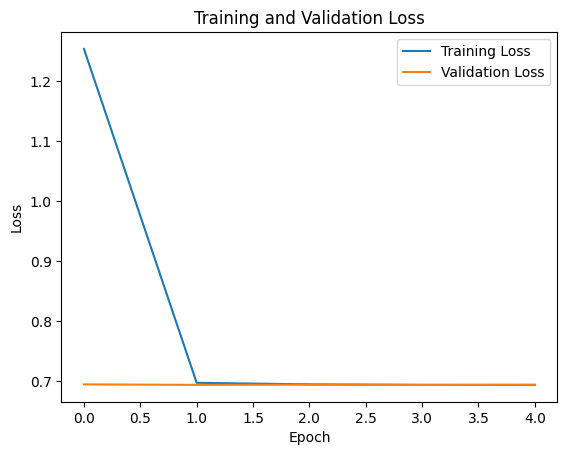

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 25088)             0         
                                                                 
 dense_15 (Dense)            (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_16 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 27561282 (105.14 MB)
Trainable params: 12846594 (49.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
19/19

In [16]:
train_vgg16_model()

# VGG-LSTM

In [41]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Dropout, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def train_vgg16_cnn_lstm_model():
    # Load pre-trained VGG16 model without top layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers for classification
    vgg16_model = base_model.output
    vgg16_model = Flatten()(vgg16_model)
    vgg16_model = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(vgg16_model)
    vgg16_model = Dropout(0.6)(vgg16_model)
    vgg16_model = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(vgg16_model)
    vgg16_model = Dropout(0.6)(vgg16_model)

    # Add CNN-LSTM layers
    cnn_lstm_model = Reshape((1, 512))(vgg16_model)
    cnn_lstm_model = LSTM(256, return_sequences=True, kernel_regularizer=l2(0.01))(cnn_lstm_model) #L2
    cnn_lstm_model = Dropout(0.6)(cnn_lstm_model)
    cnn_lstm_model = LSTM(256, kernel_regularizer=l2(0.01))(cnn_lstm_model)
    cnn_lstm_model = Dropout(0.6)(cnn_lstm_model)

    # Add output layer
    num_classes = 4  # 클래스 개수 설정
    output = Dense(num_classes, activation='softmax')(cnn_lstm_model)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile model
    optimizer = Adam(lr=study.best_params['lr'])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Fine-tuning: Unfreeze some layers and train the entire model with new data
    for layer in model.layers:
        if 'block4' in layer.name or 'block5' in layer.name:  # Unfreeze layers starting from 'block4'
            layer.trainable = True

    # Define early stopping callback
    #early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Data augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Train the model with early stopping and data augmentation
    batch_size = study.best_params['batch_size']
    train_generator = train_datagen.flow(X_train, y_train_one_hot, batch_size=batch_size)
    steps_per_epoch = len(X_train) // batch_size

    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        validation_data=(X_val, y_val_one_hot),
        epochs=50
    )

    # Plot training history
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    # Evaluate the model
    model.summary()
    val_loss, val_acc = model.evaluate(X_val, y_val_one_hot)
    print('val accuracy:', val_acc)
    test_loss, test_acc = model.evaluate(X_test, y_test_one_hot)
    print('Test accuracy:', test_acc)

Epoch 1/50
175/175 [==============================] - 34s 171ms/step - loss: 4.3363 - accuracy: 0.5107 - val_loss: 1.1387 - val_accuracy: 0.5017
Epoch 2/50
175/175 [==============================] - 29s 167ms/step - loss: 0.8866 - accuracy: 0.5046 - val_loss: 0.7593 - val_accuracy: 0.5017
Epoch 3/50
175/175 [==============================] - 29s 167ms/step - loss: 0.7259 - accuracy: 0.5079 - val_loss: 0.7072 - val_accuracy: 0.5017
Epoch 4/50
175/175 [==============================] - 29s 167ms/step - loss: 0.7010 - accuracy: 0.5007 - val_loss: 0.6974 - val_accuracy: 0.5017
Epoch 5/50
175/175 [==============================] - 29s 165ms/step - loss: 0.6957 - accuracy: 0.5064 - val_loss: 0.6944 - val_accuracy: 0.5017
Epoch 6/50
175/175 [==============================] - 29s 167ms/step - loss: 0.6942 - accuracy: 0.4979 - val_loss: 0.6937 - val_accuracy: 0.5017
Epoch 7/50
175/175 [==============================] - 29s 166ms/step - loss: 0.6937 - accuracy: 0.5014 - val_loss: 0.6935 - val_ac

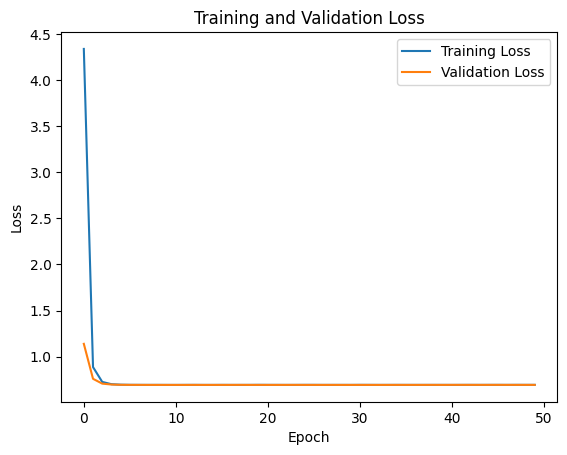

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [42]:
train_vgg16_cnn_lstm_model()